In [1]:
import cv2
import numpy as np
from PIL import Image, ImageEnhance

table_image = cv2.imread(r"C:\Users\weili\Pictures\Screenshots\Screenshot 2023-12-18 154231.png")

def preprocess(img, factor: int):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = Image.fromarray(img)
    enhancer = ImageEnhance.Sharpness(img).enhance(factor)
    if gray.std() < 30:
        enhancer = ImageEnhance.Contrast(enhancer).enhance(factor)
    return np.array(enhancer)

gray = cv2.cvtColor(table_image, cv2.COLOR_BGR2GRAY)
thresh, img_bin = cv2.threshold(
    gray, 128, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
img_bin = 255-img_bin

kernel_len = gray.shape[1]//120
hor_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (kernel_len, 1))
image_horizontal = cv2.erode(img_bin, hor_kernel, iterations=3)
horizontal_lines = cv2.dilate(image_horizontal, hor_kernel, iterations=3)

h_lines = cv2.HoughLinesP(
    horizontal_lines, 1, np.pi/180, 30, maxLineGap=250)



In [2]:
def group_h_lines(h_lines, thin_thresh):
    new_h_lines = []
    while len(h_lines) > 0:
        thresh = sorted(h_lines, key=lambda x: x[0][1])[0][0]
        lines = [line for line in h_lines if thresh[1] -
                 thin_thresh <= line[0][1] <= thresh[1] + thin_thresh]
        h_lines = [line for line in h_lines if thresh[1] - thin_thresh >
                   line[0][1] or line[0][1] > thresh[1] + thin_thresh]
        x = []
        for line in lines:
            x.append(line[0][0])
            x.append(line[0][2])
        x_min, x_max = min(x) - int(5*thin_thresh), max(x) + int(5*thin_thresh)
        new_h_lines.append([x_min, thresh[1], x_max, thresh[1]])
    return new_h_lines
    
new_horizontal_lines = group_h_lines(h_lines, kernel_len)


In [3]:
kernel_len = gray.shape[1]//120
ver_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, kernel_len))
image_vertical = cv2.erode(img_bin, ver_kernel, iterations=3)
vertical_lines = cv2.dilate(image_vertical, ver_kernel, iterations=3)

v_lines = cv2.HoughLinesP(vertical_lines, 1, np.pi/180, 30, maxLineGap=250)

def group_v_lines(v_lines, thin_thresh):
    new_v_lines = []
    while len(v_lines) > 0:
        thresh = sorted(v_lines, key=lambda x: x[0][0])[0][0]
        lines = [line for line in v_lines if thresh[0] -
                 thin_thresh <= line[0][0] <= thresh[0] + thin_thresh]
        v_lines = [line for line in v_lines if thresh[0] - thin_thresh >
                   line[0][0] or line[0][0] > thresh[0] + thin_thresh]
        y = []
        for line in lines:
            y.append(line[0][1])
            y.append(line[0][3])
        y_min, y_max = min(y) - int(4*thin_thresh), max(y) + int(4*thin_thresh)
        new_v_lines.append([thresh[0], y_min, thresh[0], y_max])
    return new_v_lines
    
new_vertical_lines = group_v_lines(v_lines, kernel_len)


In [4]:
def seg_intersect(line1: list, line2: list):
    a1, a2 = line1
    b1, b2 = line2
    da = a2-a1
    db = b2-b1
    dp = a1-b1

    def perp(a):
        b = np.empty_like(a)
        b[0] = -a[1]
        b[1] = a[0]
        return b

    dap = perp(da)
    denom = np.dot(dap, db)
    num = np.dot(dap, dp)
    return (num / denom.astype(float))*db + b1


In [5]:
points = []
for hline in new_horizontal_lines:
    x1A, y1A, x2A, y2A = hline
    for vline in new_vertical_lines:
        x1B, y1B, x2B, y2B = vline

        line1 = [np.array([x1A, y1A]), np.array([x2A, y2A])]
        line2 = [np.array([x1B, y1B]), np.array([x2B, y2B])]

        x, y = seg_intersect(line1, line2)
        if x1A <= x <= x2A and y1B <= y <= y2B:
            points.append([int(x), int(y)])


In [6]:
def get_bottom_right(right_points, bottom_points, points):
    for right in right_points:
        for bottom in bottom_points:
            if [right[0], bottom[1]] in points:
                return right[0], bottom[1]
    return None, None

cells = []
for point in points:
    left, top = point
    right_points = sorted(
        [p for p in points if p[0] > left and p[1] == top], key=lambda x: x[0])
    bottom_points = sorted(
        [p for p in points if p[1] > top and p[0] == left], key=lambda x: x[1])

    right, bottom = get_bottom_right(
        right_points, bottom_points, points)
    if right and bottom:
        cv2.rectangle(table_image, (left, top), (right, bottom), (0, 0, 255), 2)
        cells.append([left, top, right, bottom])


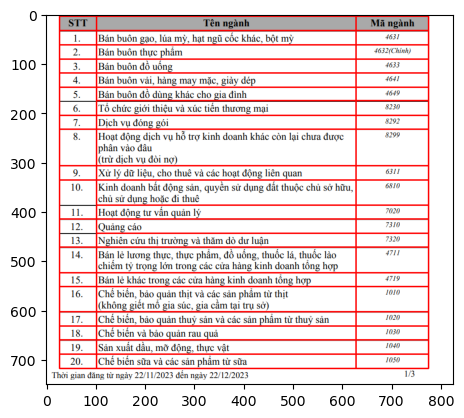

In [7]:
import matplotlib.pyplot as plt

plt.imshow(cv2.cvtColor(table_image, cv2.COLOR_BGR2RGB))
plt.show()

In [9]:
import pytesseract
import cv2
import pandas as pd

# Assuming you have already defined the 'cells' list and 'table_image' variable

ma_so = []

for cell in cells:
    left, top, right, bottom = cell
    roi = table_image[top:bottom, left:right]
    if right>755:
        
    # Chuyển ảnh sang đen trắng để cải thiện khả năng nhận diện
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Áp dụng ngưỡng để tách nền và chữ
        _, threshold_roi = cv2.threshold(gray_roi, 150, 255, cv2.THRESH_BINARY)

    # Sử dụng Tesseract để nhận diện văn bản
        text = pytesseract.image_to_string(threshold_roi, lang='vie')

        # In kết quả
        print(f"Text in cell ({left}, {top}) to ({right}, {bottom}): {text}")

        # Vẽ bounding box lên ảnh gốc
        cv2.rectangle(table_image, (left, top), (right, bottom), (0, 0, 255), 2)

        maso = pytesseract.image_to_string(threshold_roi, lang='vie')
        ma_so.append(maso)
            
        
ten_nganh = []

for cell in cells:
    left, top, right, bottom = cell
    roi = table_image[top:bottom, left:right]
    if right>102 and left < 628 :
        
    # Chuyển ảnh sang đen trắng để cải thiện khả năng nhận diện
        gray_roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)

        # Áp dụng ngưỡng để tách nền và chữ
        _, threshold_roi = cv2.threshold(gray_roi, 150, 255, cv2.THRESH_BINARY)

    # Sử dụng Tesseract để nhận diện văn bản
        text = pytesseract.image_to_string(threshold_roi, lang='vie')

        # In kết quả
        print(f"Text in cell ({left}, {top}) to ({right}, {bottom}): {text}")

        # Vẽ bounding box lên ảnh gốc
        cv2.rectangle(table_image, (left, top), (right, bottom), (0, 0, 255), 2)

        tennganh = pytesseract.image_to_string(threshold_roi, lang='vie')
        ten_nganh.append(tennganh)
            


Text in cell (628, 4) to (775, 33): Mã ngành


Text in cell (628, 33) to (775, 62): đ631

Text in cell (628, 62) to (775, 91): 3632(Chính)


Text in cell (628, 91) to (775, 119): 4633


Text in cell (628, 119) to (775, 148): đó41


Text in cell (628, 148) to (775, 175): 4649


Text in cell (628, 175) to (775, 205): 4330

Text in cell (628, 205) to (775, 233): 8392


Text in cell (628, 233) to (775, 307): 8399


Text in cell (628, 307) to (775, 336): 6311


Text in cell (628, 336) to (775, 387): 6810


Text in cell (628, 387) to (775, 415): 7020


Text in cell (628, 415) to (775, 444): 2300


Text in cell (628, 444) to (775, 472): 7320


Text in cell (628, 472) to (775, 524): n


Text in cell (628, 524) to (775, 552): 4719


Text in cell (628, 552) to (775, 603): 2018


Text in cell (628, 603) to (775, 632): 2030


Text in cell (628, 632) to (775, 660): 2030


Text in cell (628, 660) to (775, 689): 2040


Text in cell (628, 689) to (775, 718): 2050


Text in cell (102, 4) to (628, 33): 

In [10]:
ma_so

['Mã ngành\n\n',
 'đ631\n',
 '3632(Chính)\n\n',
 '4633\n\n',
 'đó41\n\n',
 '4649\n\n',
 '4330\n',
 '8392\n\n',
 '8399\n\n',
 '6311\n\n',
 '6810\n\n',
 '7020\n\n',
 '2300\n\n',
 '7320\n\n',
 'n\n\n',
 '4719\n\n',
 '2018\n\n',
 '2030\n\n',
 '2030\n\n',
 '2040\n\n',
 '2050\n\n']

In [11]:
ten_nganh

['Tên ngành\n\n',
 '',
 'Bán buôn thực phẩm\n\n',
 'Bán buôn đồ uống\n\n',
 'IBán buôn vải, hàng may mặc, giày dép\n\n',
 'Bán buôn đồ dùng khác cho gia đình\n\n',
 'ITô chức giới thiệu và xúc tiền thương mại\n\n',
 'Dịch vụ đóng gói\n\n',
 'Hoạt động dịch vụ bỗ trợ kinh doanh khác còn lại chưa được\nInhân vào đâu\n4irừ dịch vụ đời nợ)\n\n',
 'lXử lý dữ liệu, cho thuê vả các hoạt động liên quan\n\n',
 'Kinh doanh bất động sản, quyền sử dụng đất thuộc chủ sở hữu,\nlchủ sử dụng hoặc đi thuê\n\n',
 'Hoạt động tư vẫn quản lý\n\n',
 'IQuảng cáo\n\n',
 'INghiên cứu thị trường và thăm dò dư luận\n\n',
 '[Bán lẻ lương thực, thực Wam đồ uống, thuốc lá, muoc lào\nlchiếm tỷ trọng lớn trong các cửa hảng kinh doanh tổng hợp\n\n',
 'Bán lẻ khác trong các cửa hàng kinh doanh tỗng hợp\n\n',
 'Chế biến, bảo quản thịt và các sản phẩm từ thịt\nl(không giết mỏ gia súc, gia cầm tại trụ sở)\n\n',
 'IChế biến, bảo quản thuỷ sản và các sản phẩm từ thuỹ sản\n\n',
 'IChế biến và bảo quản rau quả\n\n',
 'Sản xuấ

In [12]:
dfms = pd.DataFrame(ma_so)



# Display the modified DataFrame


In [13]:
dfms.rename(columns={0: 'Mã Ngành'}, inplace=True)

In [14]:
dfms

,Mã Ngành
0,Mã ngành\n\n
1,đ631\n
2,3632(Chính)\n\n
3,4633\n\n
4,đó41\n\n
5,4649\n\n
6,4330\n
7,8392\n\n
8,8399\n\n
9,6311\n\n


In [15]:
dfms['Mã Ngành'] = dfms['Mã Ngành'].astype(str).str[:-2]
dfms

,Mã Ngành
0,Mã ngành
1,đ63
2,3632(Chính)
3,4633
4,đó41
5,4649
6,433
7,8392
8,8399
9,6311


In [16]:
dftn = pd.DataFrame(ten_nganh)


In [17]:
dftn

,0
0,Tên ngành\n\n
1,
2,Bán buôn thực phẩm\n\n
3,Bán buôn đồ uống\n\n
4,"IBán buôn vải, hàng may mặc, giày dép\n\n"
5,Bán buôn đồ dùng khác cho gia đình\n\n
6,ITô chức giới thiệu và xúc tiền thương mại\n\n
7,Dịch vụ đóng gói\n\n
8,Hoạt động dịch vụ bỗ trợ kinh doanh khác còn l...
9,"lXử lý dữ liệu, cho thuê vả các hoạt động liên..."


In [18]:
dftn.rename(columns={0: 'Tên Ngành'}, inplace=True)

In [19]:
dftn

,Tên Ngành
0,Tên ngành\n\n
1,
2,Bán buôn thực phẩm\n\n
3,Bán buôn đồ uống\n\n
4,"IBán buôn vải, hàng may mặc, giày dép\n\n"
5,Bán buôn đồ dùng khác cho gia đình\n\n
6,ITô chức giới thiệu và xúc tiền thương mại\n\n
7,Dịch vụ đóng gói\n\n
8,Hoạt động dịch vụ bỗ trợ kinh doanh khác còn l...
9,"lXử lý dữ liệu, cho thuê vả các hoạt động liên..."


In [20]:
dftn['Tên Ngành'] = dftn['Tên Ngành'].astype(str).str[:-2]
dftn

,Tên Ngành
0,Tên ngành
1,
2,Bán buôn thực phẩm
3,Bán buôn đồ uống
4,"IBán buôn vải, hàng may mặc, giày dép"
5,Bán buôn đồ dùng khác cho gia đình
6,ITô chức giới thiệu và xúc tiền thương mại
7,Dịch vụ đóng gói
8,Hoạt động dịch vụ bỗ trợ kinh doanh khác còn l...
9,"lXử lý dữ liệu, cho thuê vả các hoạt động liên..."


In [21]:
result_df = pd.concat([dftn, dfms], axis=1)

# Hiển thị kết quả
print(result_df)

                                            Tên Ngành     Mã Ngành
0                                           Tên ngành     Mã ngành
1                                                              đ63
2                                  Bán buôn thực phẩm  3632(Chính)
3                                    Bán buôn đồ uống         4633
4               IBán buôn vải, hàng may mặc, giày dép         đó41
5                  Bán buôn đồ dùng khác cho gia đình         4649
6          ITô chức giới thiệu và xúc tiền thương mại          433
7                                    Dịch vụ đóng gói         8392
8   Hoạt động dịch vụ bỗ trợ kinh doanh khác còn l...         8399
9   lXử lý dữ liệu, cho thuê vả các hoạt động liên...         6311
10  Kinh doanh bất động sản, quyền sử dụng đất thu...         6810
11                           Hoạt động tư vẫn quản lý         7020
12                                         IQuảng cáo         2300
13          INghiên cứu thị trường và thăm dò dư luận         

In [22]:
result_df = result_df.drop(0)

# Reset lại index nếu cần thiết
result_df.reset_index(drop=True, inplace=True)
result_df

,Tên Ngành,Mã Ngành
0,,đ63
1,Bán buôn thực phẩm,3632(Chính)
2,Bán buôn đồ uống,4633
3,"IBán buôn vải, hàng may mặc, giày dép",đó41
4,Bán buôn đồ dùng khác cho gia đình,4649
5,ITô chức giới thiệu và xúc tiền thương mại,433
6,Dịch vụ đóng gói,8392
7,Hoạt động dịch vụ bỗ trợ kinh doanh khác còn l...,8399
8,"lXử lý dữ liệu, cho thuê vả các hoạt động liên...",6311
9,"Kinh doanh bất động sản, quyền sử dụng đất thu...",6810
